# Import Libaries and file csv
Import Libaries

In [ ]:
import pandas as pd 
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import sklearn.metrics as metrics
import math
import os.path
from os import path
from pylab import rcParams
from random import randrange
from pandas import Series
from matplotlib import pyplot
import pickle
import os
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import CSV data file

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Dữ liệu Lịch sử VN Index.csv")
data

,Date,Close,Open,High,Low,Vol,% Change
0,2009-01-02,313.34,312.49,313.34,312.18,5.63K,-0.72%
1,2009-01-05,311.91,308.77,311.91,308.25,7.92K,-0.46%
2,2009-01-06,314.04,312.91,315.02,312.88,12.97K,0.68%
3,2009-01-07,319.58,320.40,322.59,319.29,14.75K,1.76%
4,2009-01-08,314.15,315.92,318.79,313.04,14.94K,-1.70%
...,...,...,...,...,...,...,...
3476,2022-12-06,1048.69,1093.67,1093.67,1048.69,1.48M,-4.11%
3477,2022-12-07,1041.02,1048.69,1059.79,1034.92,920.94K,-0.73%
3478,2022-12-08,1050.53,1041.02,1078.09,1041.02,916.99K,0.91%
3479,2022-12-09,1051.81,1050.53,1061.21,1041.39,788.20K,0.12%


#Prepare the Data

In [ ]:
data.Date = pd.to_datetime(data.Date, dayfirst = False)
data.set_index("Date", inplace = True)

In [ ]:
data = data[['Close']] # Just use the close price
data

,Close
Date,
2009-01-02,313.34
2009-01-05,311.91
2009-01-06,314.04
2009-01-07,319.58
2009-01-08,314.15
...,...
2022-12-06,1048.69
2022-12-07,1041.02
2022-12-08,1050.53


In [ ]:
data.describe()

,Close
count,3481.000000
mean,731.448383
std,306.115564
min,235.500000
25%,491.040000
50%,605.080000
75%,961.780000
max,1528.570000


In [ ]:
data.index

DatetimeIndex(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-12', '2009-01-13',
               '2009-01-14', '2009-01-15',
               ...
               '2022-11-29', '2022-11-30', '2022-12-01', '2022-12-02',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-12'],
              dtype='datetime64[ns]', name='Date', length=3481, freq=None)

#Test-Train split
We need to split the data into two set of data: training data and testing data
Using eighty percent of data for training and the remaining twenty percent for testing. This 80/20 split is the most common approach 


In [ ]:
size_train = int(len(data)*0.80) 
train_data = data[0:size_train] 
test_data = data[size_train:]

In [ ]:
pd_train = pd.DataFrame(train_data['Close']) 
pd_test = pd.DataFrame(test_data['Close'])
print("Tập train:")
print(pd_train.describe())
print("") 
print("Tập test:")
print(pd_test.describe())

Tập train:
             Close
count  2784.000000
mean    622.874131
std     211.935501
min     235.500000
25%     470.660000
50%     565.345000
75%     738.360000
max    1204.330000

Tập test:
             Close
count   697.000000
mean   1165.122296
std     231.159789
min     659.210000
25%     947.240000
50%    1195.530000
75%    1351.170000
max    1528.570000


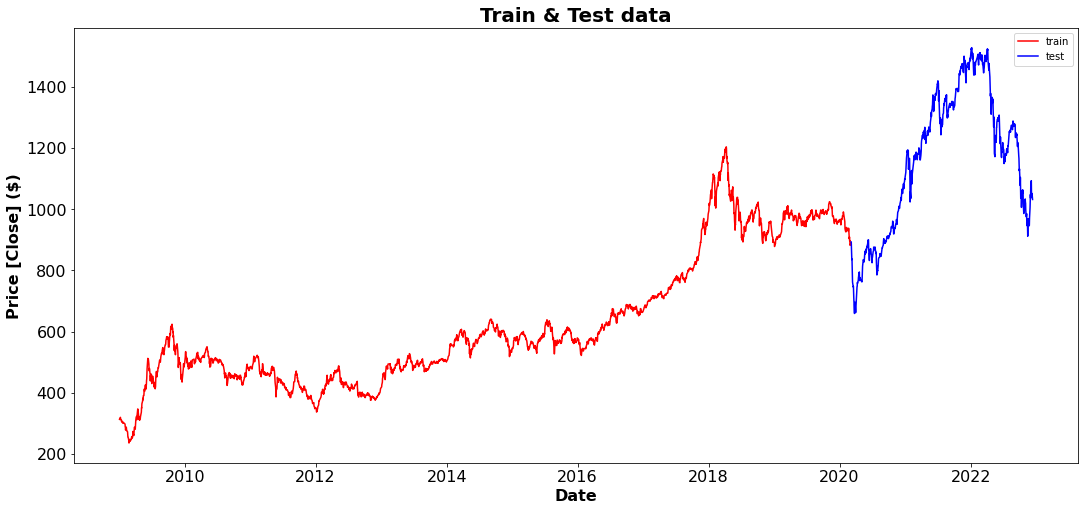

In [ ]:
fig, ax = plt.subplots(figsize=(18,8)) # 4.5, 2
sns.lineplot(x = data.index[:size_train], y = data['Close'][:size_train], color = 'red')
sns.lineplot(x = data.index[size_train:], y = data['Close'][size_train:], color = 'blue')
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close] ($)', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data['Close'], time_step)
X_test, y_test = create_dataset(test_data['Close'], time_step)


In [ ]:
X_train_copy = X_train
y_train_copy = y_train
X_test_copy = X_test
y_test_copy = y_test

In [ ]:
scaler_test = MinMaxScaler(feature_range=(0,1))
scaler_train = MinMaxScaler(feature_range=(0,1))

X_train = scaler_train.fit_transform(X_train)
X_test  = scaler_test.fit_transform(X_test)
y_train = scaler_train.fit_transform(y_train.reshape(-1,1))
y_test = scaler_test.fit_transform(y_test.reshape(-1,1))

#Building the model


In [ ]:
model_RDFR = RandomForestRegressor()
model_RDFR.fit(X_train, y_train)

<ipython-input-15-2a3b2a828a46>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RDFR.fit(X_train, y_train)


RandomForestRegressor()

In [ ]:
n_estimators = list(range(200, 2000, 200))
max_features = ['auto', 'sqrt', None, 'log2']
max_depth = list(range(10, 110, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10, 20, 30, 40]
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [ ]:

RDFR = RandomForestRegressor()

model_RDFR= RandomizedSearchCV(estimator = RDFR, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
model_RDFR.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
           

In [ ]:
print(model_RDFR.best_params_)

{'n_estimators': 600, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40, 'bootstrap': False}


In [ ]:
model_RDFR_update = RandomForestRegressor(n_estimators= 600, min_samples_split= 30, min_samples_leaf= 1, max_features= None, max_depth= 40, bootstrap= False)
model_RDFR_update.fit(X_train, y_train)

<ipython-input-15-c03ec68d2412>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RDFR_update.fit(X_train, y_train)


RandomForestRegressor(bootstrap=False, max_depth=40, max_features=None,
                      min_samples_split=30, n_estimators=600)

#Predict on test data and visualize 

In [ ]:
y_pred_test_RDFR = model_RDFR_update.predict(X_test)


In [ ]:
y_pred_test_RDFR = scaler_test.inverse_transform(y_pred_test_RDFR.reshape(-1,1))

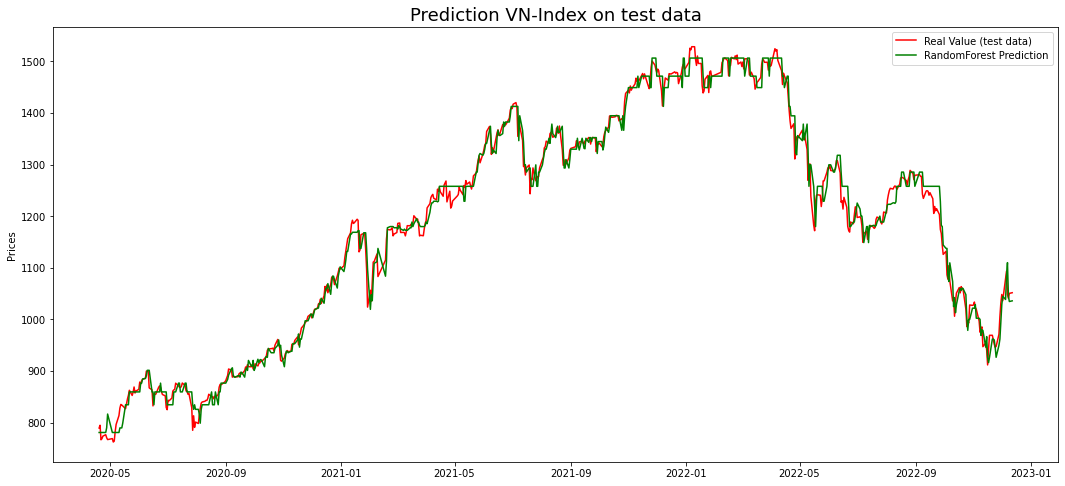

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(data.index[2815:], y_test_copy, color="red", label=f"Real Value (test data)")
plt.plot(data.index[2815:], y_pred_test_RDFR, color="green", label = 'RandomForest Prediction')
plt.title('Prediction VN-Index on test data', fontsize=18)
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel("Prices")
plt.legend()

#Visualize train data

In [ ]:
y_pred_train_RDFR = model_RDFR_update.predict(X_train)

In [ ]:
y_pred_train_RDFR = scaler_train.inverse_transform(y_pred_train_RDFR.reshape(-1,1))

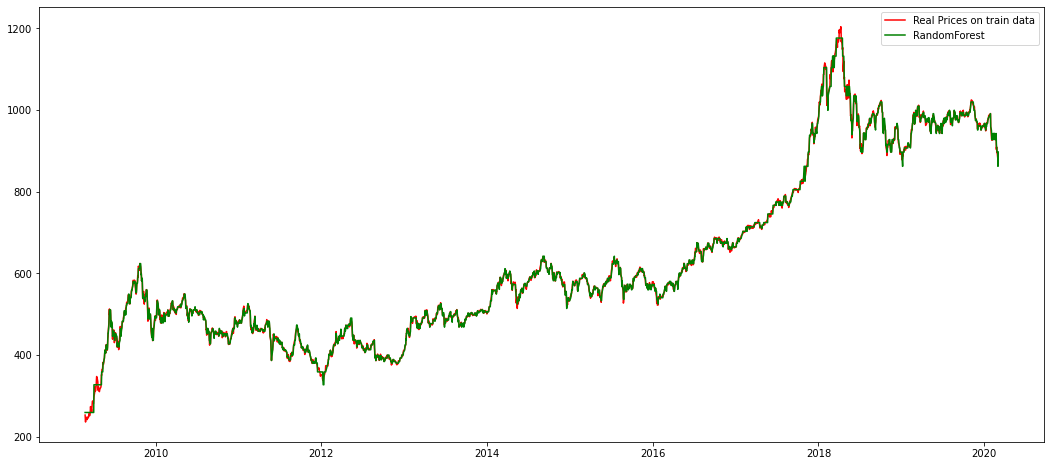

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(data.index[31:2784], y_train_copy ,color="red", label = 'Real Prices on train data')
plt.plot(data.index[31:2784],y_pred_train_RDFR, color="green", label = 'RandomForest')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.legend()

#Review model

In [ ]:
print("TẬP TEST                           TẬP TRAIN")
print("Random Forest")
print("MSE  : " + str(mean_squared_error(y_test_copy, y_pred_test_RDFR))                
+"  ||  "  + str(mean_squared_error(y_train_copy, y_pred_train_RDFR)))
print("MAE  : " + str(mean_absolute_error(y_test_copy, y_pred_test_RDFR))               
+" ||  " + str(mean_absolute_error(y_train_copy, y_pred_train_RDFR)))
print("MAPE : " + str(mean_absolute_percentage_error(y_test_copy, y_pred_test_RDFR)*100)
+"  ||  "  + str(mean_absolute_percentage_error(y_train_copy, y_pred_train_RDFR)*100))
print("R2   : " + str(round(metrics.r2_score(y_test_copy, y_pred_test_RDFR), 15))
+"  ||  "  + str(round(metrics.r2_score(y_train_copy, y_pred_train_RDFR), 15)))

TẬP TEST                           TẬP TRAIN
Random Forest
MSE  : 398.6878641044951  ||  38.527003460399314
MAE  : 14.629988524059389 ||  4.210915336052945
MAPE : 1.269701615941337  ||  0.724772231396198
R2   : 0.99159554837355  ||  0.999128020266828


#Predicting index in next 30 days

In [ ]:
Prediction_RDFR_30days = X_test[[len(X_test)-1]]

In [ ]:
i = 0
while i < 30:
  Prediction_RDFR_30days = np.append(Prediction_RDFR_30days, model_RDFR_update.predict(Prediction_RDFR_30days))
  Prediction_RDFR_30days = np.delete(Prediction_RDFR_30days, 0)
  Prediction_RDFR_30days = Prediction_RDFR_30days.reshape(1,30)
  i = i + 1

In [ ]:
Prediction_RDFR_30days = scaler_test.inverse_transform(Prediction_RDFR_30days)

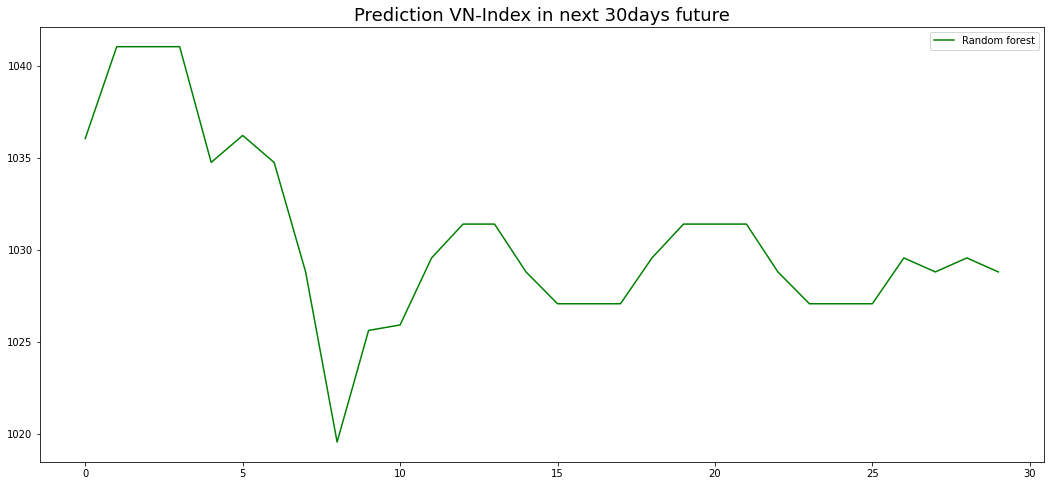

In [ ]:
plt.figure(figsize= (18, 8))
plt.plot(Prediction_RDFR_30days[0,:], color="green", label ="Random forest")
plt.title('Prediction VN-Index in next 30days future', fontsize=18)
plt.legend()